In [ ]:
!git clone https://github.com/deepanshudashora/custom_models.git

Cloning into 'custom_models'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 47 (delta 20), reused 30 (delta 10), pack-reused 0
Receiving objects: 100% (47/47), 14.39 KiB | 7.20 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
!pip3 install torch_lr_finder -q
!pip3 install torchinfo -q
!pip3 install grad-cam -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
# Initialized Logger
import torch
import torch.optim as optim
from torchvision import datasets
import albumentations as A
from torchsummary import summary
from albumentations.pytorch import ToTensorV2
from custom_models.utils import plot_accuracy_report, \
                  show_random_results, plot_misclassified, \
                  plot_trueclassified, \
                  calculate_accuracy_per_class, \
                  implement_onecycle_policy, \
                  generate_gradcam, \
                  plot_gradcam

from custom_models.dataset import dataset_stats,\
                        visualize_images,\
                        visualize_augmentated_images,\
                        Cifar10SearchDataset
from custom_models.models.resnet import ResNet18
from custom_models.main import get_device, fit_model

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


CODE BLOCK: 2

In [2]:
# CUDA?
device = get_device()
print("Available Device :: ", device)

INFO:custom_models.main:device: cuda


Available Device ::  cuda


CODE BLOCK: 3

In [3]:
sample = datasets.CIFAR10('./data',train=True,download=True)
sample_data = sample.data

mean,std,var = dataset_stats(sample_data)
print(f"SHAPE of Images {sample_data.shape}")
print(f"MEAN of dataset {mean}")
print(f"STD of dataset {std}")
print(f"VAR of dataset {var}")

Files already downloaded and verified
SHAPE of Images (50000, 32, 32, 3)
MEAN of dataset [0.49139968 0.48215841 0.44653091]
STD of dataset [0.24703223 0.24348513 0.26158784]
VAR of dataset [15.56135559 15.11767693 17.44919073]


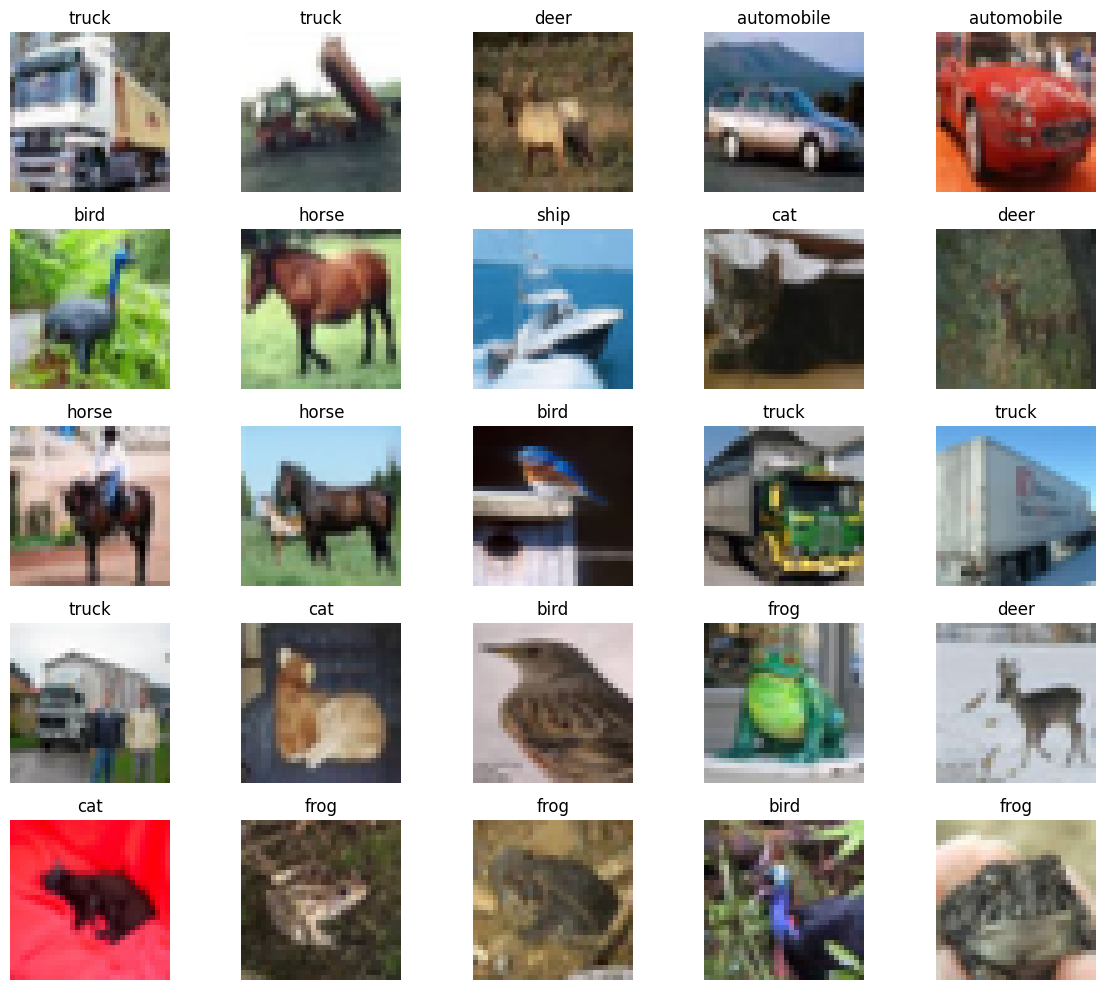

In [4]:
visualize_images(sample,(5,5))

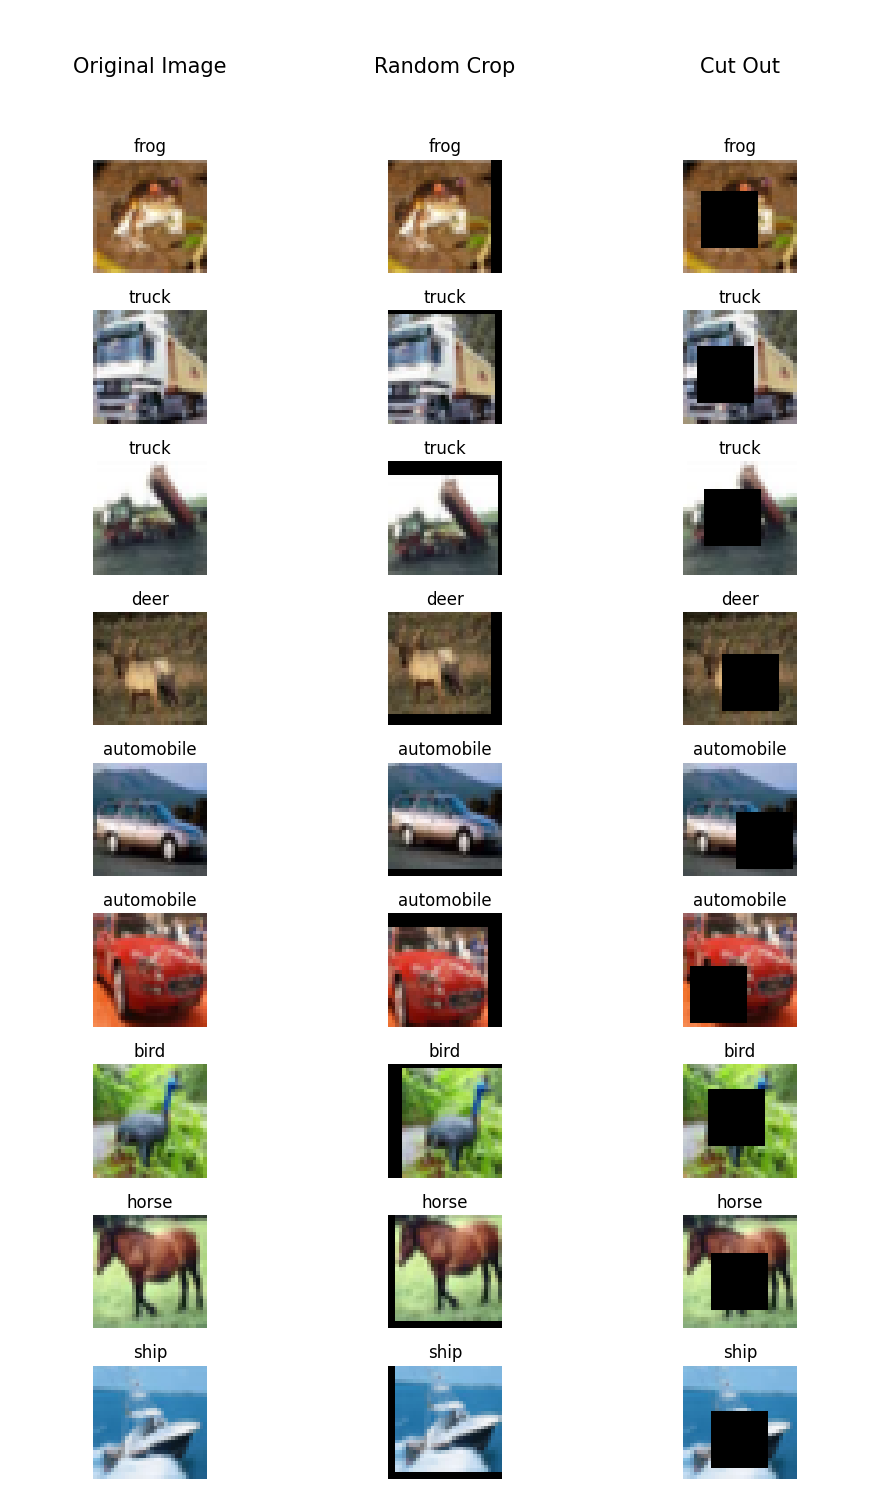

In [5]:
aug_details = {
    'Original Image': None,
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16,
                               min_width=16, fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
      }

visualize_augmentated_images(sample,aug_details)

In [6]:
train_transforms = A.Compose(
    [
      A.Normalize(mean, std),
      A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16,
                            min_width=16, fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
      ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
      A.Normalize(mean, std),
      ToTensorV2(),
    ]
)

train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


In [7]:
from torchinfo import summary
model = ResNet18().to(device)
summary(model, input_size=(512,3, 32, 32),depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [512, 10]                 --
├─Conv2d: 1-1                            [512, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [512, 64, 32, 32]         128
├─Sequential: 1-3                        [512, 64, 32, 32]         --
│    └─BasicBlock: 2-1                   [512, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [512, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [512, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [512, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [512, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [512, 64, 32, 32]         --
│    └─BasicBlock: 2-2                   [512, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [512, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [512, 64, 32, 32]         

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.74E-02


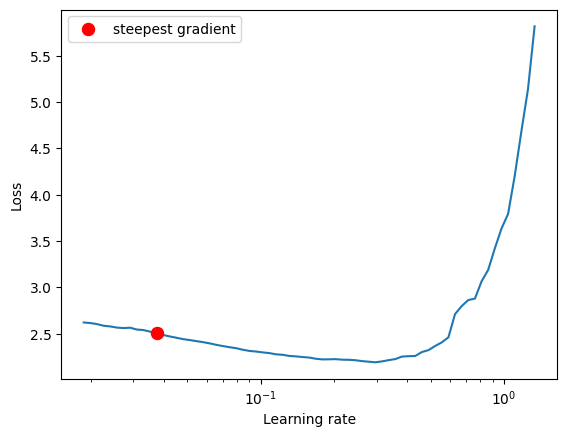

In [8]:
configuration = {'learning_rate':0.01,
                 'weight_decay':1e-4,
                 'end_lr':5,
                 'num_iterations':100,
                 'step_mode':'exp'

                 }
implement_onecycle_policy(ResNet18,configuration,device,train_loader)

In [9]:
training_parameters = {"learning_rate":0.01,
                       "max_lr":3.74E-02,
                       "max_at":3/20,
                       "num_epochs":20,
                       "weight_decay":1e-4
                       }
train_losses, test_losses, train_acc, test_acc = fit_model(model,training_parameters,train_loader,test_loader,device)

Epoch 1


Train: Loss=1.6364 Batch_id=97 Accuracy=35.51: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0564, Accuracy: 3884/10000 (38.84%)

Epoch 2


Train: Loss=1.4104 Batch_id=97 Accuracy=45.80: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0514, Accuracy: 3983/10000 (39.83%)

Epoch 3


Train: Loss=1.4250 Batch_id=97 Accuracy=50.49: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]


Test set: Average loss: 0.0448, Accuracy: 4842/10000 (48.42%)

Epoch 4


Train: Loss=1.1565 Batch_id=97 Accuracy=54.29: 100%|██████████| 98/98 [00:49<00:00,  1.96it/s]


Test set: Average loss: 0.0383, Accuracy: 5381/10000 (53.81%)

Epoch 5


Train: Loss=1.0228 Batch_id=97 Accuracy=58.86: 100%|██████████| 98/98 [00:49<00:00,  1.96it/s]


Test set: Average loss: 0.0515, Accuracy: 4866/10000 (48.66%)

Epoch 6


Train: Loss=0.9836 Batch_id=97 Accuracy=61.04: 100%|██████████| 98/98 [00:49<00:00,  1.97it/s]


Test set: Average loss: 0.0455, Accuracy: 5561/10000 (55.61%)

Epoch 7


Train: Loss=1.1080 Batch_id=97 Accuracy=62.36: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Test set: Average loss: 0.0398, Accuracy: 5824/10000 (58.24%)

Epoch 8


Train: Loss=1.0524 Batch_id=97 Accuracy=64.50: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0304, Accuracy: 6604/10000 (66.04%)

Epoch 9


Train: Loss=1.0755 Batch_id=97 Accuracy=65.23: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Test set: Average loss: 0.0576, Accuracy: 4762/10000 (47.62%)

Epoch 10


Train: Loss=1.0056 Batch_id=97 Accuracy=66.89: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Test set: Average loss: 0.0557, Accuracy: 4853/10000 (48.53%)

Epoch 11


Train: Loss=0.8460 Batch_id=97 Accuracy=67.26: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 0.0474, Accuracy: 5280/10000 (52.80%)

Epoch 12


Train: Loss=0.9837 Batch_id=97 Accuracy=68.83: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 0.0205, Accuracy: 7402/10000 (74.02%)

Epoch 13


Train: Loss=0.8317 Batch_id=97 Accuracy=70.21: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s]


Test set: Average loss: 0.0275, Accuracy: 6564/10000 (65.64%)

Epoch 14


Train: Loss=0.7942 Batch_id=97 Accuracy=71.58: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Test set: Average loss: 0.0246, Accuracy: 6434/10000 (64.34%)

Epoch 15


Train: Loss=0.7884 Batch_id=97 Accuracy=72.67: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s]


Test set: Average loss: 0.0276, Accuracy: 6494/10000 (64.94%)

Epoch 16


Train: Loss=0.8380 Batch_id=97 Accuracy=73.91: 100%|██████████| 98/98 [00:48<00:00,  2.00it/s]


Test set: Average loss: 0.0186, Accuracy: 7571/10000 (75.71%)

Epoch 17


Train: Loss=0.6678 Batch_id=97 Accuracy=75.68: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s]


Test set: Average loss: 0.0202, Accuracy: 7881/10000 (78.81%)

Epoch 18


Train: Loss=0.6053 Batch_id=97 Accuracy=77.26: 100%|██████████| 98/98 [00:48<00:00,  2.00it/s]


Test set: Average loss: 0.0143, Accuracy: 8207/10000 (82.07%)

Epoch 19


Train: Loss=0.5517 Batch_id=97 Accuracy=79.63: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s]


Test set: Average loss: 0.0124, Accuracy: 8426/10000 (84.26%)

Epoch 20


Train: Loss=0.5737 Batch_id=97 Accuracy=81.87: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 0.0078, Accuracy: 8660/10000 (86.60%)



In [ ]:
test_loss_cpu = []
for i in test_losses:
  test_loss_cpu.append(i.cpu().numpy())

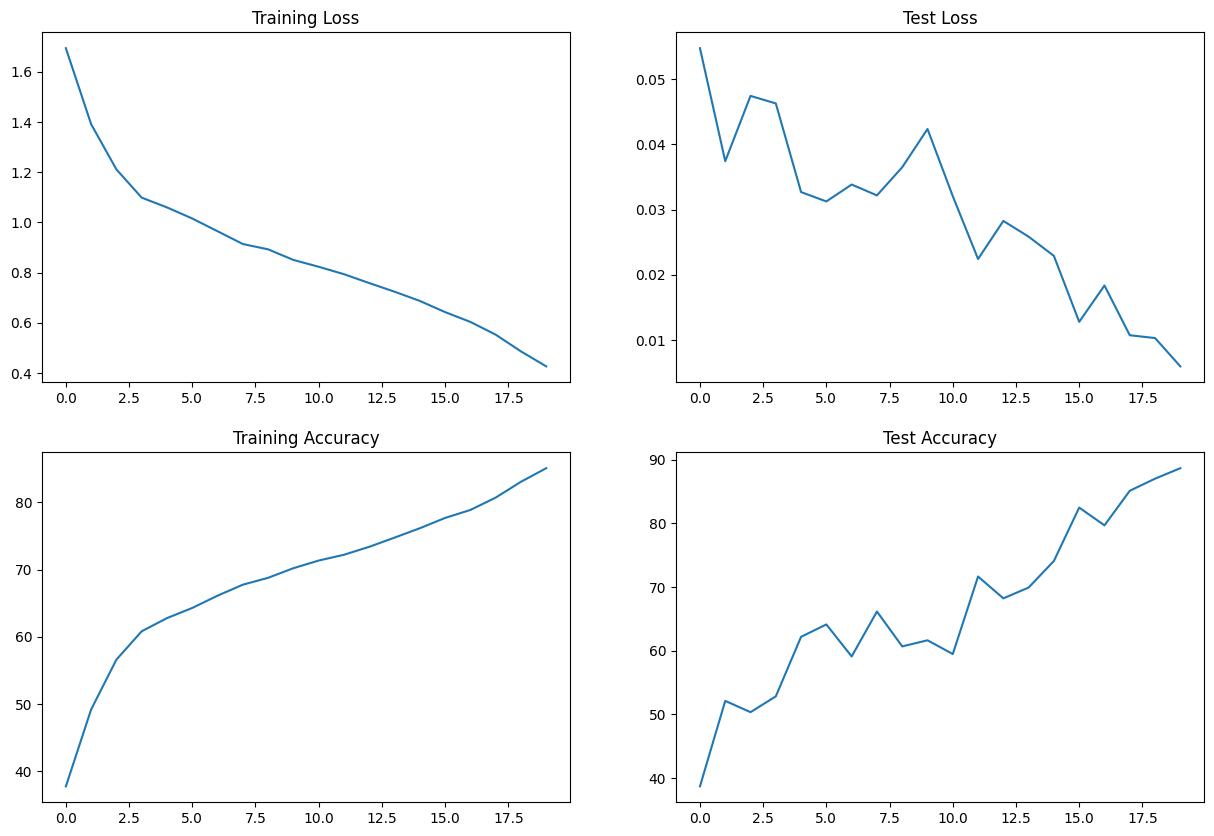

In [ ]:
plot_accuracy_report(train_losses, test_loss_cpu, train_acc, test_acc)

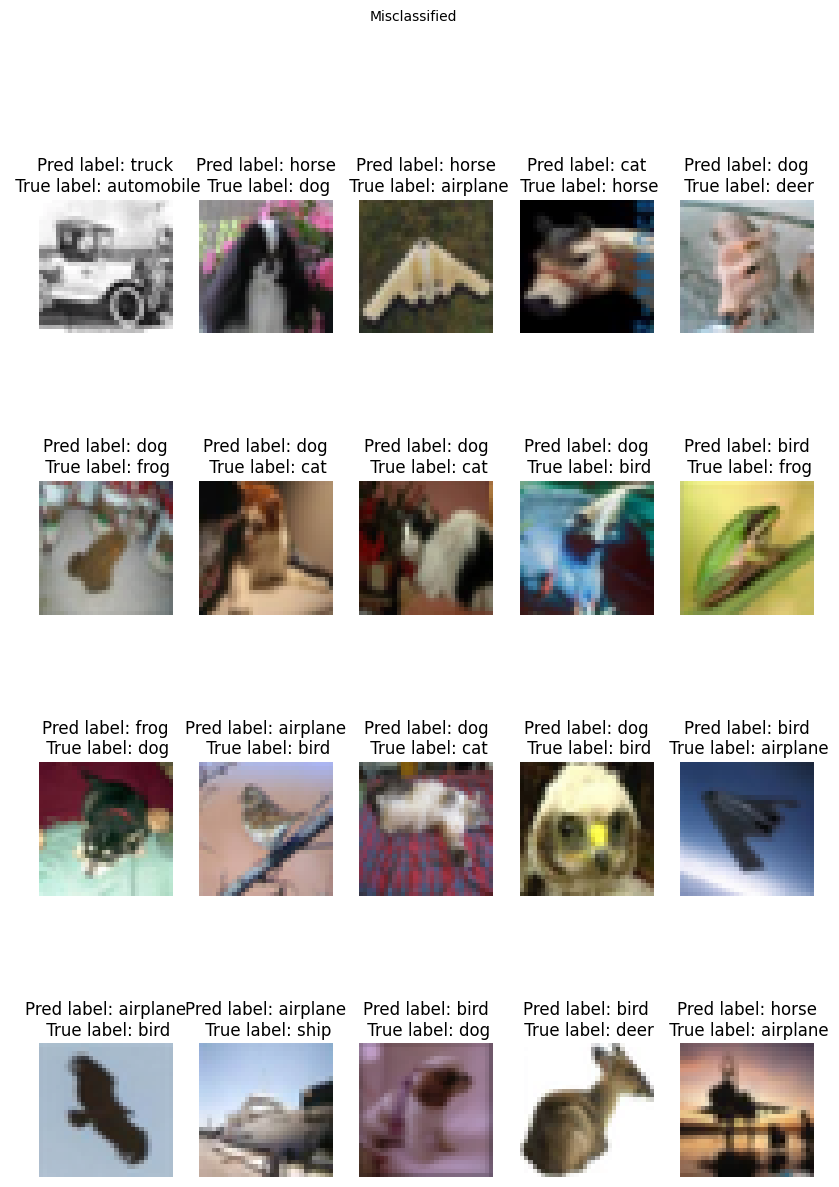

In [ ]:
grid_size = (4,5)
missclassified_images_list = plot_misclassified(model,test_loader,test,device,mean,std,grid_size)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


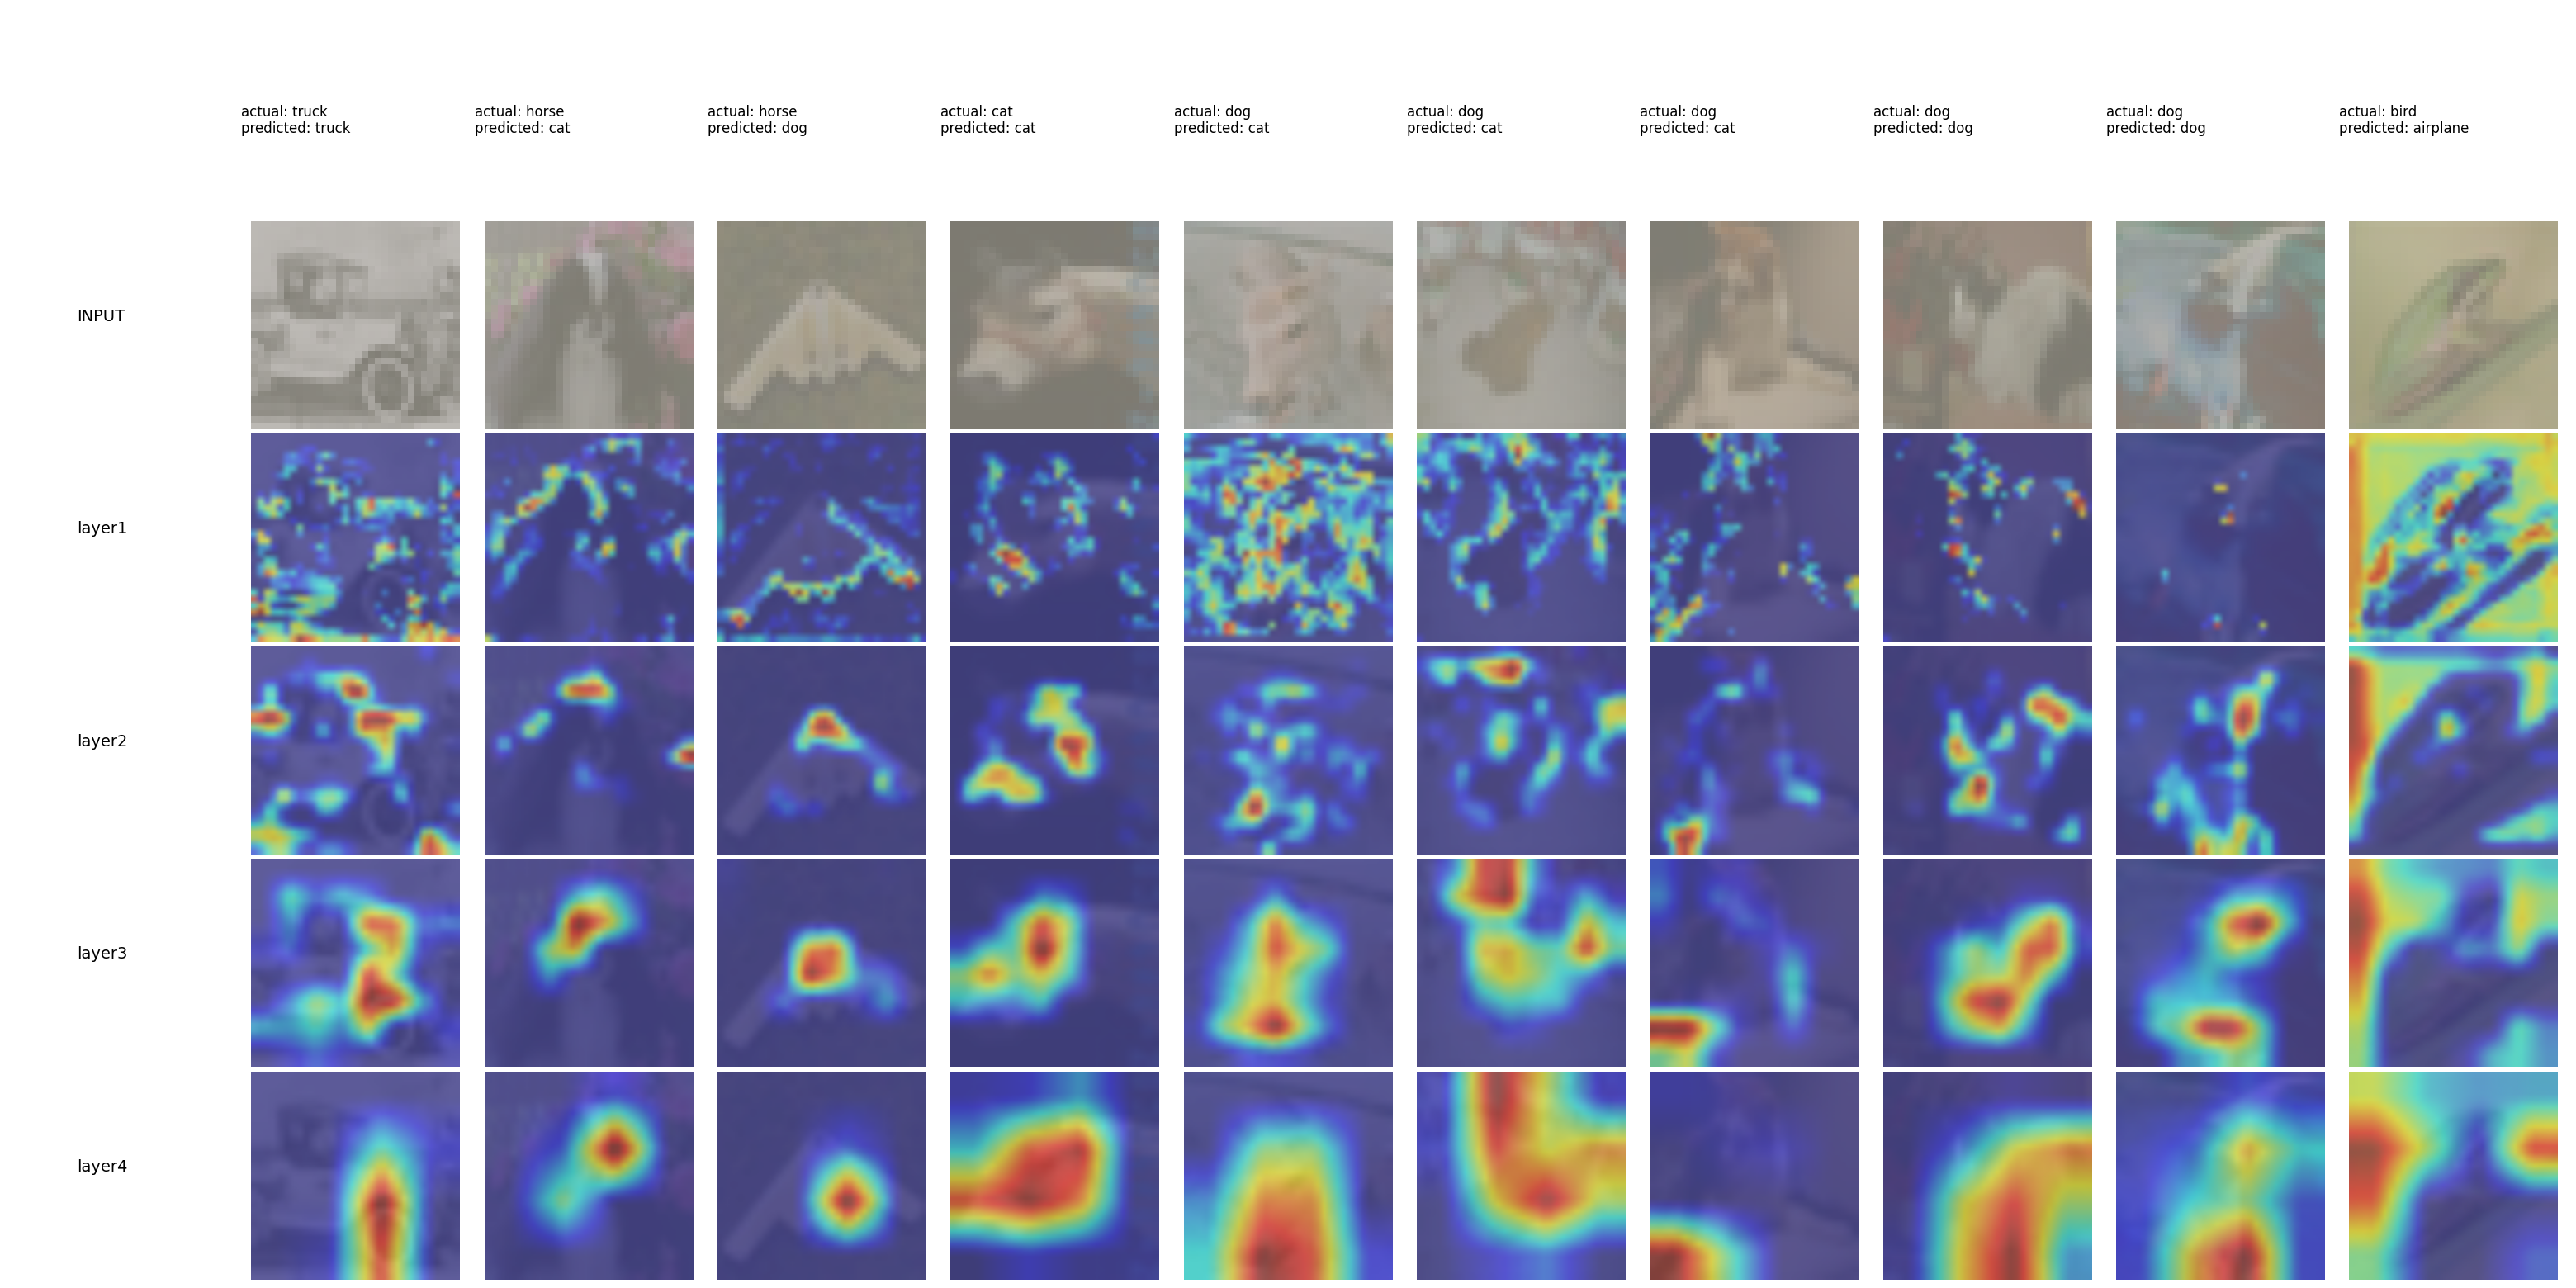

In [ ]:
classes = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

target_layers = ["layer1","layer2","layer3","layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(missclassified_images_list[:10], model, target_layers,device)
plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, missclassified_images_list[:10],mean,std)

In [ ]:
test.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']


Accuracy of airplane : 95 %

Accuracy of automobile : 100 %

Accuracy of  bird : 66 %

Accuracy of   cat : 61 %

Accuracy of  deer : 95 %

Accuracy of   dog : 100 %

Accuracy of  frog : 100 %

Accuracy of horse : 100 %

Accuracy of  ship : 88 %

Accuracy of truck : 85 %
{'airplane': 95.45454545454545, 'automobile': 100.0, 'bird': 66.66666666666667, 'cat': 61.904761904761905, 'deer': 95.45454545454545, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 88.23529411764706, 'truck': 85.71428571428571}


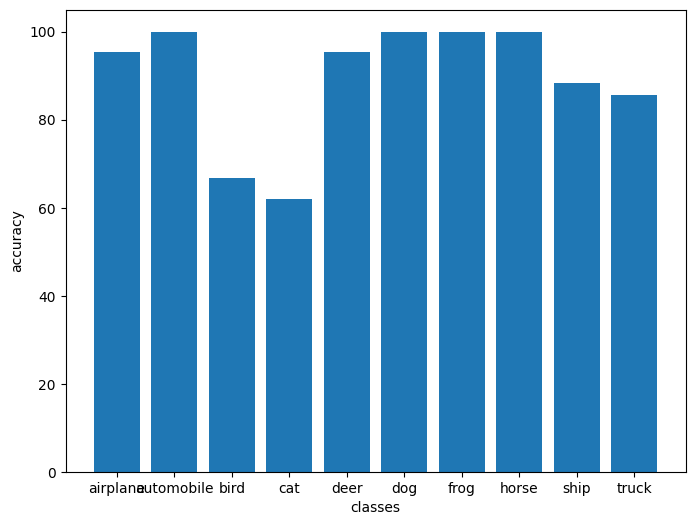

In [ ]:
calculate_accuracy_per_class(model,device,test_loader,test)

In [ ]:
torch.save(model.state_dict(), "cifar_85.pth")